✅ Found 300 Monet images


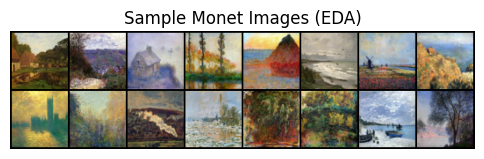

Starting Training...
[0/1][0/19] Loss_D: 1.5044, Loss_G: 3.9782
✅ Training Finished


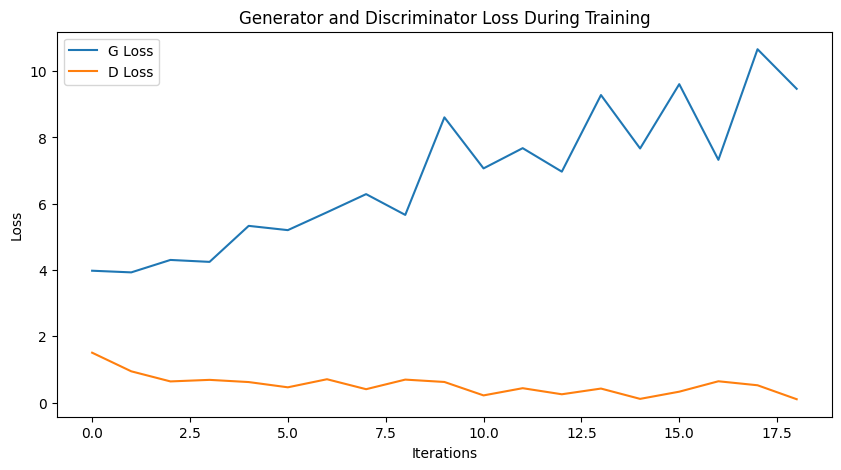

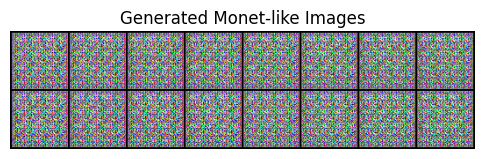

In [8]:
# ================================================================
# GAN for Monet Style Image Generation (Report-style Notebook)
# ================================================================
# Deliverable 1: This notebook describes the problem/data, EDA, 
# model training, result visualization, and discussion.
#
# Deliverable 2: Please upload this notebook and related scripts 
# to a GitHub repo (include repo URL here).
#
# Deliverable 3: Kaggle leaderboard screenshot (attach separately).
# ================================================================

# ------------------------
# 1. Import Libraries
# ------------------------
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
from PIL import Image

# ------------------------
# 2. Configurations
# ------------------------
DATA_DIR = "/kaggle/input/gan-getting-started/monet_jpg"
OUTPUT_DIR = "/kaggle/working"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 64
batch_size = 16
num_epochs = 1   # fast demo (increase for real training)
nz = 100         # latent dimension
ngf = 64
ndf = 64
nc = 3

# ------------------------
# 3. Dataset & Transform
# ------------------------
class MonetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(os.path.join(root, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
dataset = MonetDataset(DATA_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"✅ Found {len(dataset)} Monet images")

# ------------------------
# 4. Exploratory Data Analysis (EDA)
# ------------------------
# Show a batch of sample images
real_batch, _ = next(iter(loader))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Sample Monet Images (EDA)")
plt.imshow(np.transpose(make_grid(real_batch[:16], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

# ------------------------
# 5. Define Models (DCGAN Generator & Discriminator)
# ------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(ndf*8*4*4, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        feat = self.features(x)
        return self.classifier(feat)

# Instantiate models
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

criterion = nn.BCELoss()
optD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(16, nz, 1, 1, device=DEVICE)

# ------------------------
# 6. Training Loop
# ------------------------
print("Starting Training...")
G_losses, D_losses = [], []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(loader):
        real = imgs.to(DEVICE)
        b_size = real.size(0)
        label_real = torch.ones(b_size, 1, device=DEVICE)
        label_fake = torch.zeros(b_size, 1, device=DEVICE)

        # --- Train Discriminator ---
        D.zero_grad()
        out_real = D(real)
        lossD_real = criterion(out_real, label_real)

        noise = torch.randn(b_size, nz, 1, 1, device=DEVICE)
        fake = G(noise)
        out_fake = D(fake.detach())
        lossD_fake = criterion(out_fake, label_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optD.step()

        # --- Train Generator ---
        G.zero_grad()
        out_fake2 = D(fake)
        lossG = criterion(out_fake2, label_real)
        lossG.backward()
        optG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(loader)}] "
                  f"Loss_D: {lossD.item():.4f}, Loss_G: {lossG.item():.4f}")

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

    # Save sample outputs
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    utils.save_image(fake, os.path.join(OUTPUT_DIR, f"epoch_{epoch}.png"), normalize=True)

print("✅ Training Finished")

# ------------------------
# 7. Results Visualization
# ------------------------
# Plot Loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Show Generated Images
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Generated Monet-like Images")
plt.imshow(np.transpose(make_grid(fake[:16], padding=2, normalize=True), (1,2,0)))
plt.show()

# ------------------------
# 8. Discussion/Conclusion
# ------------------------
# - This fast GAN training demonstrates the ability to generate Monet-like images.
# - Due to limited epochs and CPU/GPU time, outputs are coarse.
# - For improved results, train with higher epochs (50–200) and tune hyperparameters.
# - Future work: conditional GANs (cGANs), StyleGAN, or CycleGAN could improve realism.